# Dataset과 Dataloader
- 코드의 더 나은 가독성과 모듈성을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적이다.
- 파이토치는 `torch.utils.data.DataLoader`와 `torch.utils.data.Dataset`의 두 가지 데이터 기본 요소를 제공하여 미리 준비된 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 한다.
- `Dataset`은 샘플과 정답(label)을 저장하고, DataLoader는 Dataset을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다.

### 데이터셋 불러오기
- root는 학습/테스트 데이터가 저장되는 경로
- train은 학습용 또는 테스트용 데이터셋 여부를 지정
- download=True는 root에 데이터가 없는 경우 인터넷에서 다운로드
- transform과 target_transform은 특징(feature)과 변형(transform)을 지정

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
"""FashionMNIST 데이터 불러오기 예제"""
training_data = datasets.FashionMNIST(
root = "data",
train = True,
download = True,
transform = ToTensor()
)

test_data = datasets.FashionMNIST(
root = "data",
train = False,
download = True,
transform = ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw

Processing...


C:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


----

### 데이터셋을 순회하고 시각화하기
- Dataset에 리스트처럼 직접 접근(index)할 수 있다. training_data[index].matplotlib을 사용하여 학습 데이터의 일부를 시각화한다.

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

3 3 1
3 3 2
3 3 3
3 3 4
3 3 5
3 3 6
3 3 7
3 3 8
3 3 9


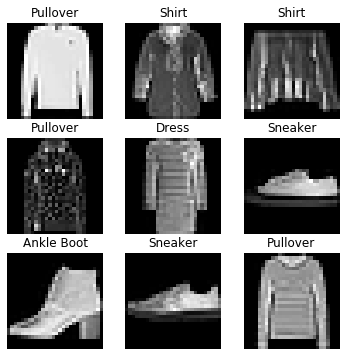

In [27]:
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # 60000개 중에서 size를 1로 하여 뽑기
    img, label = training_data[sample_idx]
    print(rows, cols, i)
    figure.add_subplot(rows, cols, i) # 3x3 행렬에서 i번째 요소를 선택
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") # 0번째 차원을 줄여줌
plt.show()

In [17]:
# 튜플 size 3으로 하여 3~5 사이의 숫자를 뽑으라
torch.randint(3, 5, (3,))

tensor([3, 4, 3])

In [26]:
# 튜플 size (2,2)로 하여 0~10까지의 수를 뽑으라
torch.randint(10, (2, 2))

tensor([[7, 2],
        [5, 6]])

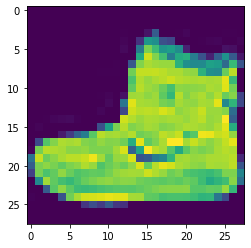

In [31]:
img, label = training_data[0]
plt.imshow(img.squeeze())

In [33]:
print(img.size())

print(img.squeeze().size())

torch.Size([28, 28])

-------

### 파일에서 사용자 정의 데이터셋 만들기
- 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 합니다: __init__, __len__, and __getitem__. 아래 구현을 살펴보면 FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file csv 파일에 별도로 저장됩니다.

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    """__init__함수는 Dataset 객체가 생성될 때 한 번만 실행된다. 이미지 주석 파일(annotation file)이 포함된 디렉토리와 두가지 변형(transform)을 초기화한다."""
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        # img_labels는 정답 csv 파일을 의미한다.
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    """__len__함수는 데이터셋의 샘플 개수를 반환한다."""
    def __len__(self):
        return len(self.img_labels)

    """__getitem__함수는 주어진 인덱스 idx에 해당하는 샘플을 데이터셋에서 불러오고 반환한다. 인덱스를 기반으로 디스크에서 이미지의 위치를 식별하고, `read_image`를 사용하여 이미지를 텐서로 변환하고, 
    self.img_labels의 csv 데이터로부터 해당하는 정답(label)을 가져오고, (해당하는 경우) 변형(transform)함수들을 호출한 뒤, 텐서 이미지와 라벨을 python 사전형으로 반환한다.
    """
    def __getitem__(self, idx):
        ## 경로와 파일명을 결합하거나 분할된 경로를 하나로 정리하는 것이 가능 -> 이 경우 self.img_dir과 self.img_labels를 결합
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        
        ## 위의 매개변수에서 transform을 True로 했다면 실행
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        ## 데이터를 사전형으로 반환
        sample = {"image": image, "label": label}
        return sample

In [39]:
## os.path.join 예시
import os
list_path = ['C:/', 'Users', 'user'] 
folder_path = os.path.join(*list_path)
folder_path

'C:/Users\\user'

In [40]:
import os 
print("join(): " + os.path.join(os.getcwd(), "file.py"))

join(): C:\Users\RohSeungChan\Desktop\sps. Lab\연구\file.py


---------

### DataLoader로 학습용 데이터 준비하기
- Dataset은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답을 지정하는 일을 한 번에 합니다. 모델을 학습할 때, 일반적으로 샘플들을 minibatch로 전달하고,
- 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, Python의 multiprocessing을 사용하여 데이터 검색 속도를 높이려고 한다.

In [42]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### DataLoader를 통해 순회하기 (iterate)
- DataLoader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있습니다. 
- 아래의 각 순회(iteration)는 각각 batch_size=64의 특징(feature)과 정답(label)을 포함하는 train_features와 train_labels의 묶음(batch)을 반환한다. 
- shuffle=True로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞입니다.

In [43]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


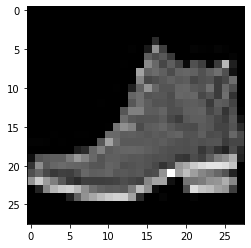

Label: 9


In [44]:
## 0번째 차
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

-----

# 변형 (TRANSFORM)
- 데이터가 항상 머신러닝 알고리즘 학습에 필요한 최종 처리가 된 형태로 제공되지는 않는다. -> transform은 데이터를 조작하고 학습에 적합하게 만든다.
- torchvision.transforms 모듈은 주로 사용하는 몇가지 변형(transform)을 제공한다.
- 학습을 할 때 유용하게 하기 위해 정규화(normalize)된 텐서 형태의 특징(feature)과 원핫(one-hot)으로 부호화(encode)된 텐서 형태의 정답(label)이 필요하다.
- 이러한 변형을 하귀 위해 `ToTensor`와 `Lambda`를 사용한다.

In [48]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False, # 이미 다운로드가 되어있기 때문에 False로 지정
    transform=ToTensor(), # 텐서형태로 다운로드
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)) # 원핫인코딩으로 변환
)

In [57]:
img, label = ds[0]
img.shape
# 원핫인코딩 형식으로 변환된 것을 알 수 있다.
print(label)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


In [58]:
torch.zeros(10, dtype=torch.float)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
## scatter_(dim, index, src, reduce = None)
# tensor.scatter_() 형태로 동작하며, 파라미터로 주어진 "index"에 맞게 "src"의 값을 새로운 "tensor"로 할당
src = torch.arange(1, 11).reshape((2, 5))
src
# tensor([[ 1,  2,  3,  4,  5],
#         [ 6,  7,  8,  9, 10]])
index = torch.tensor([[0, 1, 2, 0]])
torch.zeros(3, 5, dtype=src.dtype).scatter_(0, index, src)
#tensor([[1, 0, 0, 4, 0],
#        [0, 2, 0, 0, 0],
#        [0, 0, 3, 0, 0]])